In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import sys
from pathlib import Path
from collections import Counter

# Añadir directorio raíz al path
sys.path.append(str(Path().resolve().parent))

from src.config import PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE, TEST_SIZE, TARGET_COLUMN

# Cargar datos procesados
df = pd.read_csv(PROCESSED_DATA_DIR / "startup_data_processed.csv")

# Eliminar columnas irrelevantes y dummies problemáticas (identificadores, fechas, nombres, ciudades, etc.)
prefijos_a_eliminar = [
    'closed', 'name', 'city', 'id', 'object', 'last', 'first', 'zip', 'Unnamed:', 'founded'
]
# Elimina cualquier columna que comience por alguno de estos prefijos
cols_problematicas = [col for col in df.columns if any(col.startswith(pref) for pref in prefijos_a_eliminar)]
df = df.drop(columns=cols_problematicas)

# Eliminar columnas irrelevantes restantes por nombre exacto
columnas_a_eliminar = [
    'Unnamed: 0', 'id', 'object_id', 'Unnamed: 6', 'state_code.1',
    'zip_code', 'city', 'name', 'closed_at',
    'founded_at', 'first_funding_at', 'last_funding_at', 'labels'
]
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

# Eliminar columnas con baja varianza (opcional, pero recomendable)
cols_baja_var = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=cols_baja_var)

# Separar features y target
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

print(f"Tamaño del conjunto de entrenamiento: {X.shape}")

Tamaño del conjunto de entrenamiento: (923, 135)



--- Entrenando Árbol de Decisión ---
Accuracy en train: 1.0000
Accuracy en test: 0.7676

Reporte de clasificación:
              precision    recall  f1-score   support

    acquired       0.83      0.80      0.82       120
      closed       0.66      0.71      0.68        65

    accuracy                           0.77       185
   macro avg       0.75      0.75      0.75       185
weighted avg       0.77      0.77      0.77       185



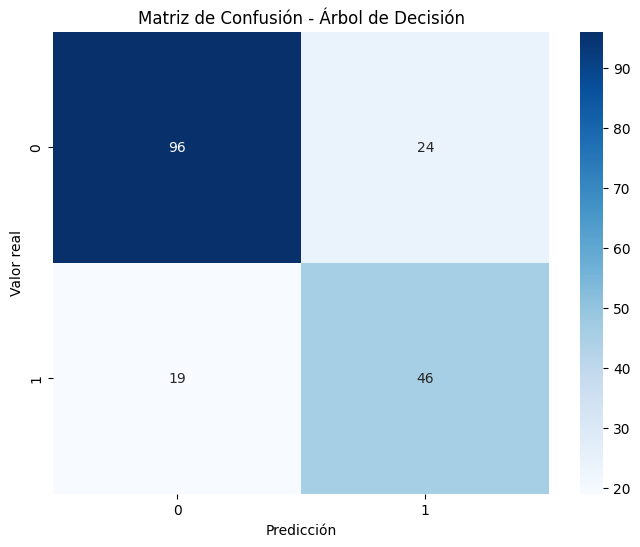

In [14]:
# Modelo base: Árbol de Decisión
print("\n--- Entrenando Árbol de Decisión ---")
dt_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_classifier.fit(X_train, y_train)

# Evaluación en train y test
dt_train_pred = dt_classifier.predict(X_train)
dt_test_pred = dt_classifier.predict(X_test)

print(f"Accuracy en train: {accuracy_score(y_train, dt_train_pred):.4f}")
print(f"Accuracy en test: {accuracy_score(y_test, dt_test_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, dt_test_pred))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, dt_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.savefig('../reports/figures/model_performance/dt_confusion_matrix.png')
plt.show()


--- Entrenando Regresión Logística ---
Accuracy en train: 0.9932
Accuracy en test: 0.8054

Reporte de clasificación:
              precision    recall  f1-score   support

    acquired       0.84      0.86      0.85       120
      closed       0.73      0.71      0.72        65

    accuracy                           0.81       185
   macro avg       0.79      0.78      0.78       185
weighted avg       0.80      0.81      0.80       185



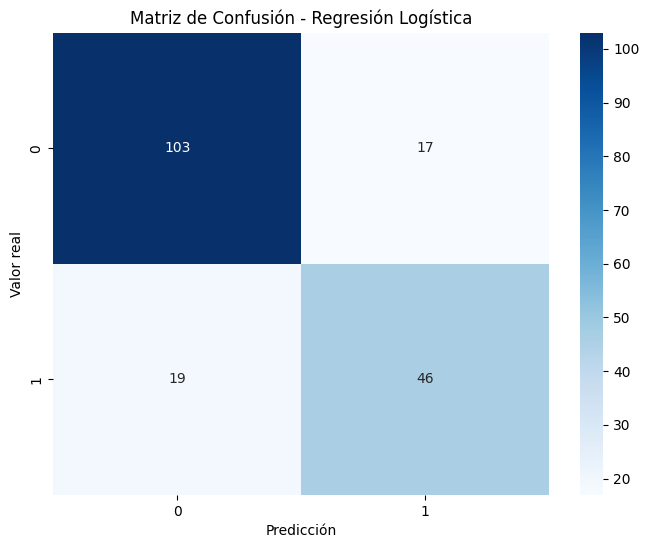

In [15]:
# Modelo baseline: Regresión Logística
print("\n--- Entrenando Regresión Logística ---")
lr_classifier = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_classifier.fit(X_train, y_train)

# Evaluación en train y test
lr_train_pred = lr_classifier.predict(X_train)
lr_test_pred = lr_classifier.predict(X_test)

print(f"Accuracy en train: {accuracy_score(y_train, lr_train_pred):.4f}")
print(f"Accuracy en test: {accuracy_score(y_test, lr_test_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, lr_test_pred))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, lr_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.savefig('../reports/figures/model_performance/lr_confusion_matrix.png')
plt.show()

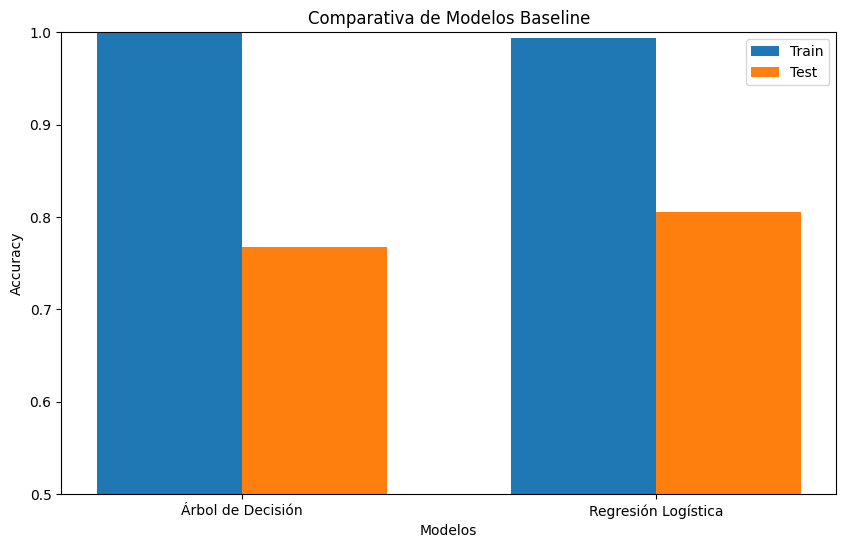

In [16]:
# Comparativa de modelos baseline
models = ['Árbol de Decisión', 'Regresión Logística']
train_scores = [
    accuracy_score(y_train, dt_train_pred),
    accuracy_score(y_train, lr_train_pred)
]
test_scores = [
    accuracy_score(y_test, dt_test_pred),
    accuracy_score(y_test, lr_test_pred)
]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_scores, width, label='Train')
plt.bar(x + width/2, test_scores, width, label='Test')

plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparativa de Modelos Baseline')
plt.xticks(x, models)
plt.legend()
plt.ylim(0.5, 1.0)
plt.savefig('../reports/figures/model_performance/baseline_comparison.png')
plt.show()

In [17]:
# Guardar modelos baseline
import os
os.makedirs(MODELS_DIR / "baseline", exist_ok=True)

with open(MODELS_DIR / "baseline" / "decision_tree.pkl", 'wb') as f:
    pickle.dump(dt_classifier, f)

with open(MODELS_DIR / "baseline" / "logistic_regression.pkl", 'wb') as f:
    pickle.dump(lr_classifier, f)

print("Modelos baseline guardados exitosamente")

Modelos baseline guardados exitosamente


## Conclusión

En este análisis se han evaluado dos modelos baseline: un Árbol de Decisión sin restricciones y una Regresión Logística. El Árbol de Decisión alcanza una precisión perfecta sobre el conjunto de entrenamiento (accuracy = 1.00), lo que evidencia un claro sobreajuste y una baja capacidad de generalización. Por otro lado, la Regresión Logística muestra un mejor equilibrio entre el rendimiento en entrenamiento y prueba, logrando una mayor capacidad de generalización sobre datos no vistos.

Estos resultados demuestran la importancia de regularizar los modelos y utilizar enfoques más robustos para evitar el sobreajuste. Los modelos baseline sirven como referencia fundamental para comparar y justificar mejoras en futuras etapas del proyecto.